# Research Dataset Preparation
This notebook prepares a research dataset to analyze the relationship between audio features and song success over different eras.

In [219]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [220]:
df = pd.read_csv('data/song_hits_and_audio_features.csv')
df.isnull().sum()

Track               0
Artist              0
Year                0
Duration            0
Time_Signature      0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Popularity          0
Genre               0
dtype: int64

## Data Cleaning and Feature Engineering
<li> renaming columns to lowercase
<li> changing duration from milliseconds to minutes
<li> creating scaled cols (standardise) to later feature engineer
<li> creating new cols of features that are highly correlated

In [221]:
df = df.rename(columns={"Track": "name"})
df.columns = df.columns.str.lower()
# changing duration from milliseconds to minutes
df["duration"] = (df["duration"] / 60000).round(2)
from sklearn.preprocessing import StandardScaler

# 1 creating scaled cols (standardise) to later feature engineer
scaler = StandardScaler()

df['loudness_scaled'] = scaler.fit_transform(df[['loudness']])
df['energy_scaled'] = scaler.fit_transform(df[['energy']])
df['acousticness_scaled'] = scaler.fit_transform(df[['acousticness']])
df['danceability_scaled'] = scaler.fit_transform(df[['danceability']])
df['valence_scaled'] = scaler.fit_transform(df[['valence']])
df["era"] = pd.cut(df["year"], bins=[1889, 1969, 1979, 1989, 1999, 2009, 2029],
                   labels=["<=60s", "70s", "80s", "90s", "00s", ">=10s"])

# 2. creating new cols of features that are highly correlated
# 'intensity' and 'feel_good_factor' combine complementary features, so mean is appropriate.
df['intensity'] = df[['energy_scaled', 'loudness_scaled']].mean(axis=1)
df['feel_good_factor'] = df[['danceability_scaled', 'valence_scaled']].mean(axis=1)

# For 'production_balance', we use the difference to capture the trade-off between electronic and acoustic sounds.
df['production_balance'] = df['energy_scaled'] - df['acousticness_scaled']
df.head(20)

,name,artist,year,duration,time_signature,danceability,energy,key,loudness,mode,...,genre,loudness_scaled,energy_scaled,acousticness_scaled,danceability_scaled,valence_scaled,era,intensity,feel_good_factor,production_balance
0,Hey Jack Kerouac,"10,000 Maniacs",1987,3.44,4,0.616,0.5110,6,-15.894,1,...,Alt. Rock,-1.571182,-0.445439,-0.831545,0.248692,0.130913,80s,-1.008311,0.189802,0.386105
1,Like the Weather,"10,000 Maniacs",1987,3.94,4,0.770,0.4590,1,-17.453,1,...,Alt. Rock,-1.934635,-0.662541,-0.599940,1.175270,1.561414,80s,-1.298588,1.368342,-0.062601
2,What's the Matter Here?,"10,000 Maniacs",1987,4.85,4,0.593,0.8160,9,-7.293,1,...,Alt. Rock,0.433986,0.827945,-0.938253,0.110307,-0.207785,80s,0.630965,-0.048739,1.766197
3,Trouble Me,"10,000 Maniacs",1989,3.23,4,0.861,0.3850,2,-10.057,1,...,Alt. Rock,-0.210391,-0.971493,-0.467774,1.722793,-0.307402,80s,-0.590942,0.707695,-0.503719
4,Candy Everybody Wants,"10,000 Maniacs",1992,3.10,4,0.622,0.8760,10,-6.310,1,...,Alt. Rock,0.663154,1.078446,-0.891649,0.284792,1.178885,90s,0.870800,0.731838,1.970095
5,More Than This,"10,000 Maniacs",1992,4.09,4,0.623,0.7730,6,-8.800,1,...,Alt. Rock,0.082656,0.648418,-0.903606,0.290809,0.939804,90s,0.365537,0.615306,1.552025
6,These Are Days,"10,000 Maniacs",1992,3.66,4,0.611,0.8330,3,-7.554,1,...,Alt. Rock,0.373138,0.898920,-0.883782,0.218608,0.884018,90s,0.636029,0.551313,1.782702
7,Verdi Cries,"10,000 Maniacs",1992,4.34,4,0.367,0.0256,3,-25.309,1,...,Alt. Rock,-3.766120,-2.471998,1.933237,-1.249477,-1.566562,90s,-3.119059,-1.408020,-4.405235
8,Because the Night - Live Unplugged,"10,000 Maniacs",1993,3.72,4,0.408,0.7900,11,-8.138,0,...,Alt. Rock,0.236989,0.719394,-0.134213,-1.002790,-0.893151,90s,0.478191,-0.947971,0.853607
9,Be Like That,3 Doors Down,2000,4.43,4,0.487,0.7020,7,-6.043,1,...,Alt. Rock,0.725401,0.351991,-0.935767,-0.527468,-1.056523,00s,0.538696,-0.791995,1.287758


### Filter for songs from the past 20 years and create a binary success column

In [222]:
songs_past_20_years = df[df['era'].isin(['00s', '>=10s'])].copy()
print(f"\nTotal songs from the past 20 years: {len(songs_past_20_years)}")
print("Popularity statistics for songs from the past 20 years:")
print(songs_past_20_years['popularity'].describe(percentiles=[.7, .75, .8, .85, .9]))


Total songs from the past 20 years: 3421
Popularity statistics for songs from the past 20 years:
count    3421.000000
mean       50.317159
std        20.117759
min         0.000000
50%        52.000000
70%        63.000000
75%        66.000000
80%        69.000000
85%        72.000000
90%        76.000000
max        98.000000
Name: popularity, dtype: float64


### Define success based on an absolute popularity threshold
<li> take top 30% popularity as successful songs

In [223]:
# --- Replace 70 with your chosen absolute popularity threshold ---
ABSOLUTE_SUCCESS_THRESHOLD = 63

# Create the new, cleaner success column on your filtered DataFrame
songs_past_20_years['is_success'] = (songs_past_20_years['popularity'] >= ABSOLUTE_SUCCESS_THRESHOLD).astype(int)

# See the new class balance
print(f"\nUsing a threshold of {ABSOLUTE_SUCCESS_THRESHOLD}, we have:")
print(songs_past_20_years['is_success'].value_counts())


Using a threshold of 63, we have:
is_success
0    2368
1    1053
Name: count, dtype: int64


### Define columns and data types for analysis

In [224]:
# Config: adjust if your columns differ
GENRE_COL = 'genre'
ARTIST_COL = 'artist'
SUCCESS_COL = 'is_success'

# audio_features = ['feel_good_factor', 'intensity','production_balance', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']
audio_features = ['danceability', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo',
                  'energy', 'loudness']

songs_past_20_years = songs_past_20_years.astype({'genre': 'category', 'artist': 'category'})
songs_past_20_years[ARTIST_COL].info()


<class 'pandas.core.series.Series'>
Index: 3421 entries, 9 to 15149
Series name: artist
Non-Null Count  Dtype   
--------------  -----   
3421 non-null   category
dtypes: category(1)
memory usage: 54.3 KB


In [225]:
songs_per_artist = songs_past_20_years["artist"].value_counts()
mean_per_artist = songs_per_artist.mean()
median_per_artists = songs_per_artist.median()
print(f"average number of songs per artist : {mean_per_artist}")
print(f"median number of songs per artist : {median_per_artists}")

average number of songs per artist : 5.608196721311476
median number of songs per artist : 6.0


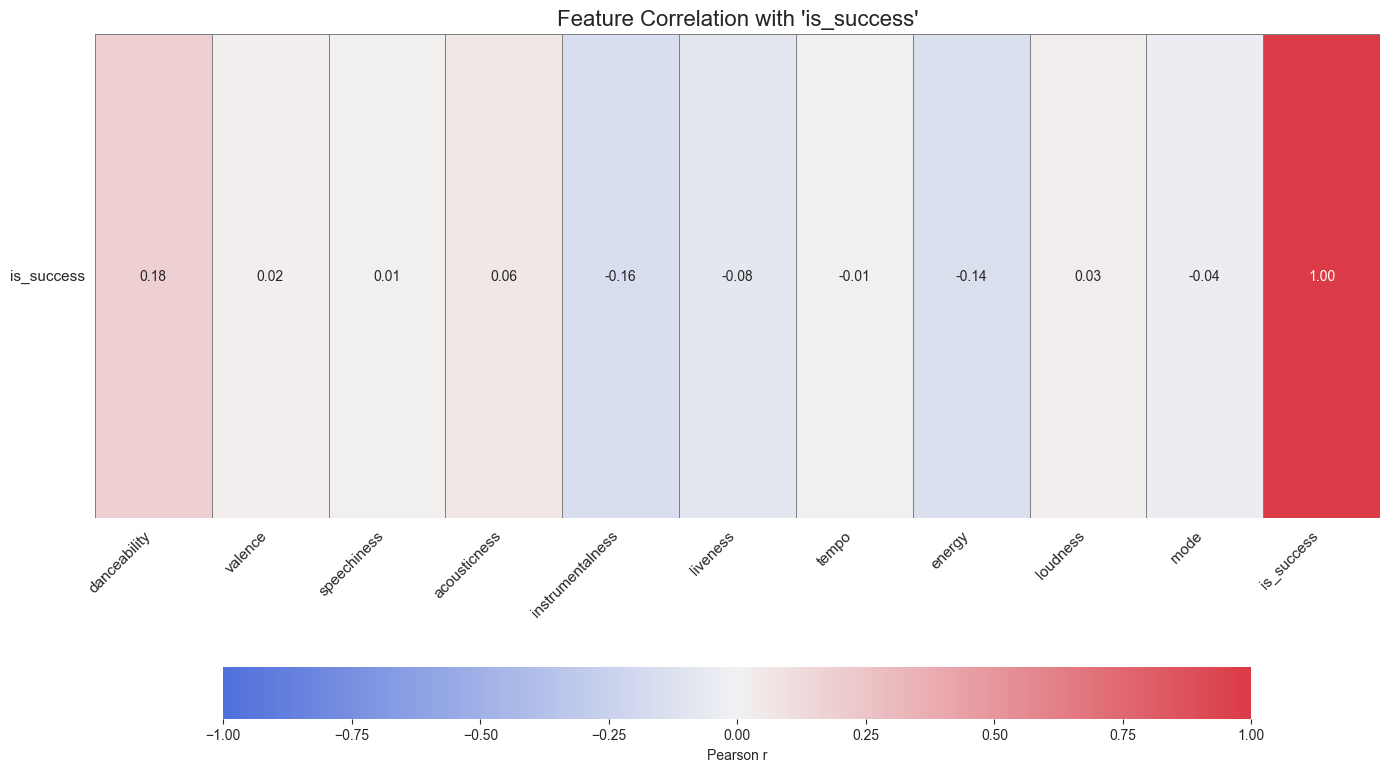

In [226]:

# --- Ensure you have a numeric success column ---
# This is a placeholder; replace 'success' with your actual numeric success column name
# and 'era' with your era column name.
SUCCESS_COL = 'is_success'

# --- Add 'mode' to the list of features for the heatmap ---
features_for_heatmap = audio_features + ['mode']
cmap = sns.diverging_palette(260, 10, n=9, as_cmap=True)

df_heatmap = songs_past_20_years[features_for_heatmap + [SUCCESS_COL]]
corrs = df_heatmap.corr()

# --- Isolate the correlations with the success column and reshape for plotting ---
corrs_target = corrs[[SUCCESS_COL]].T

fig, ax = plt.subplots(figsize=(14, 8))  # Increased height for more vertical space
sns.heatmap(
    corrs_target,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    center=0,
    linewidths=.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8, "label": "Pearson r", "orientation": "horizontal", "pad": 0.2},
    annot_kws={"size": 10},
    ax=ax
)
# Tidy ticks and title
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)  # Keep y-label horizontal
ax.set_title(f"Feature Correlation with '{SUCCESS_COL}'", fontsize=16)
plt.tight_layout()
plt.show()

Average Success Rate by Genre:
genre
Today        0.688710
Alt. Rock    0.524887
R&B          0.509091
Rap          0.464491
Country      0.428571
EDM          0.197605
Metal        0.194986
Funk         0.052632
Reggae       0.051546
Gospel       0.037267
Punk         0.028302
SKA          0.025862
Rock         0.010256
Jazz         0.000000
Blues        0.000000
Folk         0.000000
Disco        0.000000
World        0.000000
Name: is_success, dtype: float64


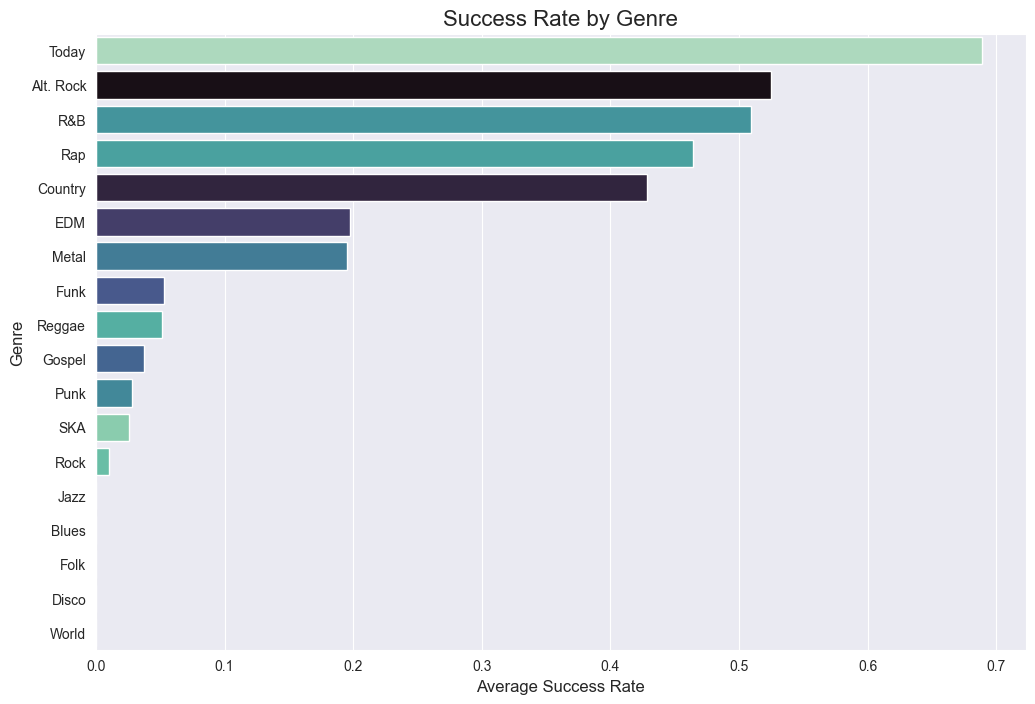

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Make sure to replace these with your actual column names ---
GENRE_COL = 'genre'
SUCCESS_COL = 'is_success'  # Assuming 1 for success, 0 for not

# Calculate the average success rate for each genre
genre_success_rate = songs_past_20_years.groupby(GENRE_COL, observed=True)[SUCCESS_COL].mean().sort_values(
    ascending=False)

print("Average Success Rate by Genre:")
print(genre_success_rate)

# Plot the results
plt.figure(figsize=(12, 8))
# --- Use the 'order' parameter to ensure the plot follows the sorted data ---
sns.barplot(
    x=genre_success_rate.values,
    y=genre_success_rate.index,
    hue = genre_success_rate.index,
    legend=False,
    order=genre_success_rate.index,  # This line enforces the correct order
    palette='mako'
)
plt.title('Success Rate by Genre', fontsize=16)
plt.xlabel('Average Success Rate', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()

#### Random Forest Classifier that take genre into account

Preprocessing the full dataset...
Training the model with balanced class weights...

Model Out-of-Bag (OOB) Accuracy: 0.780

--- OOB Metrics with Balanced Weights (0.52 Threshold) ---
              precision    recall  f1-score   support

 Not Success       0.80      0.90      0.85      2368
     Success       0.69      0.50      0.58      1053

    accuracy                           0.78      3421
   macro avg       0.75      0.70      0.72      3421
weighted avg       0.77      0.78      0.77      3421



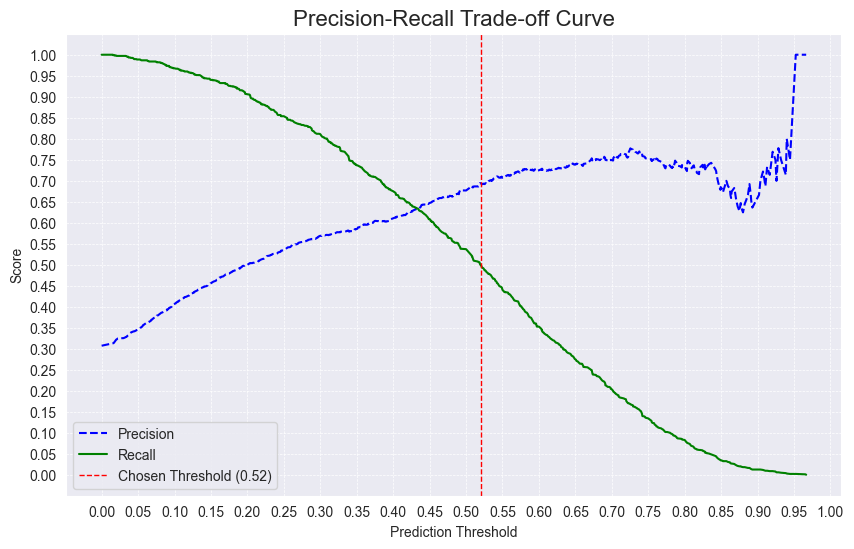

In [228]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report
import matplotlib.pyplot as plt

# --- Define your columns ---
TARGET_COL = 'is_success'
categorical_features = ['genre', 'key', 'mode']  # <-- Add key and mode here

# --- Prepare Data ---
X = songs_past_20_years[audio_features + categorical_features]
y = songs_past_20_years[TARGET_COL].astype(int)

# --- Preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', StandardScaler(), audio_features),
        # --- Apply OneHotEncoder to all categorical features ---
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)
print("Preprocessing the full dataset...")
X_transformed = preprocessor.fit_transform(X)

# --- Train the Model with Balanced Weights ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
    oob_score=True,
    class_weight='balanced'  # <--- KEY CHANGE 1: Address class imbalance
)
# # Get new predictions based on our custom threshold
# y_oob_pred_high_precision = (oob_probabilities >= NEW_THRESHOLD).astype(int)
print("Training the model with balanced class weights...")
model.fit(X_transformed, y)
print(f"\nModel Out-of-Bag (OOB) Accuracy: {model.oob_score_:.3f}")

threshold = 0.52
# --- Evaluate the balanced model (at 0.53 threshold) ---
oob_probabilities = model.oob_decision_function_[:, 1]
# y_oob_pred_balanced = np.argmax(model.oob_decision_function_, axis=1)

# maek success prediction based on threshold
y_oob_pred = (oob_probabilities >= threshold).astype(int)
print(f"\n--- OOB Metrics with Balanced Weights ({threshold} Threshold) ---")
print(classification_report(y, y_oob_pred, target_names=['Not Success', 'Success']))

# --- KEY CHANGE 2: Find and Apply a Better Threshold for High Precision ---
# Get the predicted probabilities for the "Success" class from OOB

# Generate precision-recall data
precisions, recalls, thresholds = precision_recall_curve(y, oob_probabilities)

# Plot the Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

# --- Add more detailed ticks and a clearer grid ---
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, 1.05, 0.05))
plt.grid(which='both', linestyle='--', linewidth=0.5)

# --- Add a vertical line to show the chosen threshold ---
plt.axvline(x=threshold, color='r', linestyle='--', linewidth=1, label=f'Chosen Threshold ({threshold})')

plt.title('Precision-Recall Trade-off Curve', fontsize=16)
plt.xlabel('Prediction Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

### Model Results:
The model was trained using both the raw audio features and the one-hot encoded `genre` column. Class weights were balanced t handle the imbalanced dataset.

---

#### regular audio features + genre
##### regular audio features:
<li> danceability
<li> valence
<li> speechiness
<li> acousticness
<li> instrumentalness
<li> liveness
<li> tempo
<li> energy
<li> loudness
<li> duration
<li> mode
<li> key

*   **Model Out-of-Bag (OOB) Accuracy:** 0.780


##### OOB Metrics with Balanced Weights (Default 0.5 Threshold)

```
              precision    recall  f1-score   support

 Not Success       0.80      0.89      0.84      2368
     Success       0.69      0.50      0.58      1053

    accuracy                           0.77      3421
   macro avg       0.73      0.70      0.71      3421
weighted avg       0.76      0.77      0.76      3421
```
---

#### My audio features + genre
##### my audio features:
<li> intensity
<li> production_style
<li> feel_good_factor
<li> speechiness
<li> acousticness
<li> instrumentalness
<li> liveness
<li> tempo
<li> mode
<li> key

*   **Model Out-of-Bag (OOB) Accuracy:** 0.764

##### OOB Metrics with Balanced Weights (0.52 Threshold)

```
              precision    recall  f1-score   support

 Not Success       0.80      0.89      0.84      2368
     Success       0.67      0.49      0.57      1053

    accuracy                           0.77      3421
   macro avg       0.73      0.69      0.70      3421
weighted avg       0.76      0.77      0.76      3421
```
---

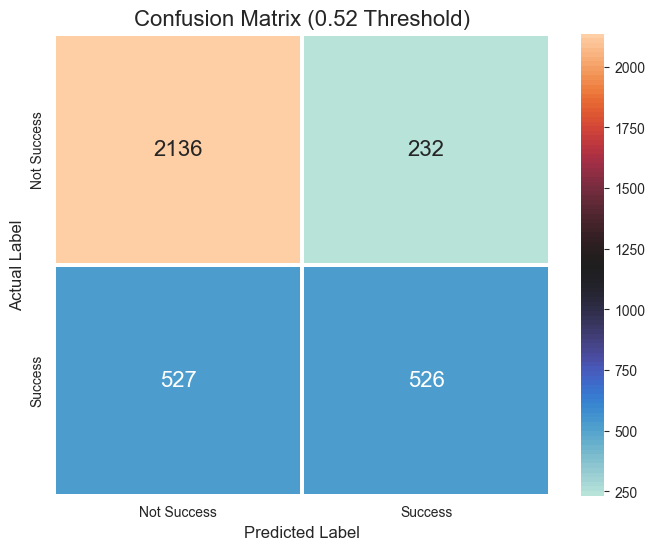

In [229]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# --- Function to plot a confusion matrix ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    # --- Create a custom green-to-blue color palette ---
    custom_cmap = sns.blend_palette(["#001cbe", "#008080"], as_cmap=True)  # from light green to dark blue
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette("icefire", 100),
                annot_kws={"size": 16},  # Increase font size of the numbers
                linewidths=1.5,
                xticklabels=['Not Success', 'Success'],
                yticklabels=['Not Success', 'Success'])
    plt.title(title, fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()


# --- 1. Plot Confusion Matrix for the model with the default 0.5 threshold ---
plot_confusion_matrix(y, y_oob_pred, f'Confusion Matrix ({threshold} Threshold)')

#### Random Forest Classifier without Genre
used to check which audio features are most important in predicting success

In [230]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score  # Import metrics

# --- Define your columns (replace if necessary) ---
TARGET_COL = 'is_success'

# --- Prepare Data using the full dataset ---
X = songs_past_20_years[audio_features]
y = songs_past_20_years[TARGET_COL].astype(int)

# --- Create and Fit the Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', StandardScaler(), audio_features),
    ],
    remainder='passthrough'
)

print("Preprocessing the full dataset...")
X_transformed = preprocessor.fit_transform(X)

# --- Get the Correct Feature Names After Transformation ---
all_feature_names = np.array(audio_features)

# --- Train the Model on the Full Dataset ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    oob_score=True
)

print("Training the model on the full dataset...")
model.fit(X_transformed, y)
print(f"\nModel Out-of-Bag (OOB) Accuracy: {model.oob_score_:.3f}")

# --- NEW: Calculate PPV (Precision) and other metrics from OOB predictions ---
# Get the OOB predictions for each song
y_oob_pred = np.argmax(model.oob_decision_function_, axis=1)

# Calculate Positive Predictive Value (Precision) for the "success" class (class 1)
ppv = precision_score(y, y_oob_pred, pos_label=1)

print(f"Positive Predictive Value (Precision) for 'Success': {ppv:.3f}")

# --- Find and Plot Feature Importance ---
print("\nCalculating feature importance...")
result = permutation_importance(
    model, X_transformed, y, n_repeats=10, random_state=42, n_jobs=-1
)

Preprocessing the full dataset...
Training the model on the full dataset...

Model Out-of-Bag (OOB) Accuracy: 0.702
Positive Predictive Value (Precision) for 'Success': 0.532

Calculating feature importance...


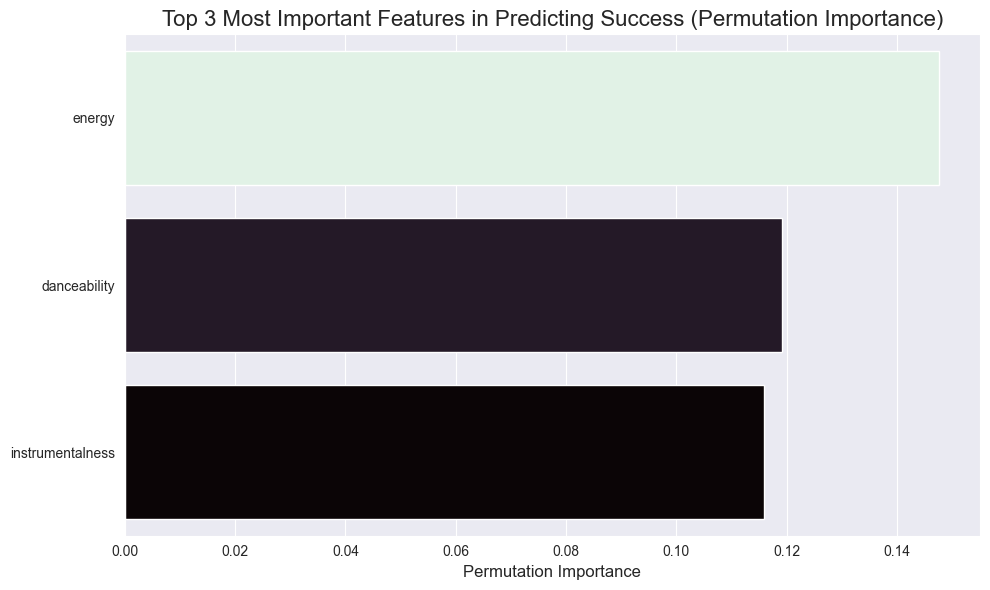


Top 3 most important features:
energy              0.147647
danceability        0.119176
instrumentalness    0.115960
dtype: float64


In [231]:
importances = pd.Series(result.importances_mean, index=all_feature_names).sort_values()

# --- Plot the Results ---
# Take the top most important features for plotting
top_importances = importances[importances >= 0.1].sort_values(ascending=False)
my_palette = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
plt.figure(figsize=(10, 6))
# --- Use seaborn.barplot for a colorful plot ---
sns.barplot(x=top_importances.values, y=top_importances.index, hue=top_importances, legend=False,
            palette='mako')
plt.title(f'Top {len(top_importances)} Most Important Features in Predicting Success (Permutation Importance)', fontsize=16)
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('')  # The feature names are the labels, so no need for a y-axis title
plt.tight_layout()
plt.show()

print(f"\nTop {len(top_importances)} most important features:")
print(top_importances)